# VAE analysis

In [1]:
import os.path
import numpy as np
import pandas as pd
import torch
import pickle
import subprocess
from matplotlib import pyplot as plt
from Bio import SeqIO
from importlib import reload
import warnings

from scipy.stats import mode
from sklearn.neighbors import KernelDensity
from skimage.graph import route_through_array
from scipy.spatial import cKDTree

import matplotlib.cm as cm

import minimal_version.parser_handler
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/
from minimal_version.preprocess_msa import Preprocessor, weight_sequences
from minimal_version.msa import MSA
from minimal_version.utils import Capturing, store_to_pkl, store_to_fasta, load_from_pkl

from minimal_version.train import setup_train, Train

%cd /Users/dahala/GitHub/VAE-enzymes/
from custom_functions import *
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


In [3]:
CONFIGURATION_FILE = "msaEVC_GmSuSy_b05.json"
#CONFIGURATION_FILE = "msaASR_NoRestrict_GmSuSy.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = False

Configuration file stored in ../results/GmSuSy_EVC_b05/config/2025-07-15_13-31.json
 Working with msaEVC_GmSuSy_b05.json configuration file!


In [13]:
HMMbuild = HMMmodule(run)
#HMMbuild.MSA_create()
HMMbuild.build()
HMMbuild.align('GmSuSy_ASR_MSA_NoRestrict',fasta_ext='fasta', save_path=run.msa)

Building HMM model...
/Users/dahala/Projects/HMMER/bin/hmmbuild --amino ../../hmm_model/GmSuSy_ASR_MSA_NoRestrict.hmm ../../alignments/muscle_outputs/GmSuSy_ASR_MSA_NoRestrict.afa > ../../hmm_model/GmSuSy_ASR_MSA_NoRestrict_hmmbuild.log
/Users/dahala/Projects/HMMER/bin/hmmalign --trim --outformat afa ../../hmm_model/GmSuSy_ASR_MSA_NoRestrict.hmm ../datasets/GmSuSy_ASR_MSA_NoRestrict.fasta > ../../alignments/GmSuSy_ASR_MSA_NoRestrict.afa


In [19]:
"""
Preprocess MSA and prepare it for VAE model training
"""

# logging
msa_log = open(os.path.join(run.logs, 'msa_log.txt'), "w")

# MSA loading
if PFAM_INPUT:
    msa = MSA.load_pfam(run.dataset)
else:
    msa = MSA.load_msa(run.dataset)
MSA.amino_acid_dict(run.pickles)
msg = f"MSA in {run.dataset} loaded\n" \
      f"number of sequences: {len(list(msa.keys()))}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')

# MSA preprocessing
preprocessor = Preprocessor(run)
with Capturing() as output:
    msa, msa_keys = preprocessor.trim_msa(msa)
msa_log.write(" MSA Preprocessing \n" + "\n".join(output) + f'\n{"="*80}\n')
assert (msa.shape[0] == len(msa_keys))
trim_file_path = os.path.join(run.msa, "trimmed_msa.fasta")
msg = f"Trimmed MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Trimmed MSA is stored at {trim_file_path}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')
msa_num_dict_shuffled = {k: seq for k, seq in zip(msa_keys, msa)}  # transform to dictionary, have keys together
# but secure that query and fixed sequences are at the beginning 
msa_num_dict = {k: msa_num_dict_shuffled[k] for k in preprocessor.keep_keys}
msa_num_dict.update({k: msa_num_dict_shuffled[k] for k in msa_num_dict_shuffled if k not in preprocessor.keep_keys})

trimmed_msa = MSA.number_to_amino(msa_num_dict)
store_to_fasta(trimmed_msa, trim_file_path)
store_to_pkl({run.query: trimmed_msa[run.query]}, os.path.join(run.pickles, "reference_seq.pkl"))

# Filtering or weighting
with Capturing() as output:
    if run.clustering:  # MSA filtering
        print(f"MSA {run.identity}% identity filtering step")
        msa_num_dict = preprocessor.identity_filtering(msa_num_dict)
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = np.ones(msa.shape[0])  # we just provide uniform weights for all sequences
    else:  # otherwise the weighting mechanism will be applied
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = weight_sequences(msa)
msa_log.write("\n".join(output))
train_msa_file_path = os.path.join(run.msa, "training_msa.fasta")
training_alg = MSA.number_to_amino(training_alg)
store_to_fasta(training_alg, train_msa_file_path)
msg = f"Training MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Training MSA is stored at {train_msa_file_path}"
print(msg)
msa_log.write(msg + f'\n{"=" * 80}\n')

store_to_pkl(seq_weight, os.path.join(run.pickles, "seq_weight.pkl"))
store_to_pkl(training_alg, os.path.join(run.pickles, "training_alignment.pkl"))

# MSA one-hot encoding
binary = MSA.number_to_binary(msa)
store_to_pkl(binary, os.path.join(run.pickles, "seq_msa_binary.pkl"))
msa_log.close()

MSA in ../datasets/GmSuSy_EVC_b05_MSA.afa loaded
number of sequences: 1180
Trimmed MSA has 1120 sequences and the width is 788
Trimmed MSA is stored at ../results/GmSuSy_EVC_b05/msa/trimmed_msa.fasta
Training MSA has 1120 sequences and the width is 788
Training MSA is stored at ../results/GmSuSy_EVC_b05/msa/training_msa.fasta


In [4]:
with open(run.pickles+ "/msa_columns.pkl", "rb") as input_file:
   msa_columns = pickle.load(input_file)

In [5]:
load_from_pkl(os.path.join(run.model, "model_params.pkl"))['model']

'vae'

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

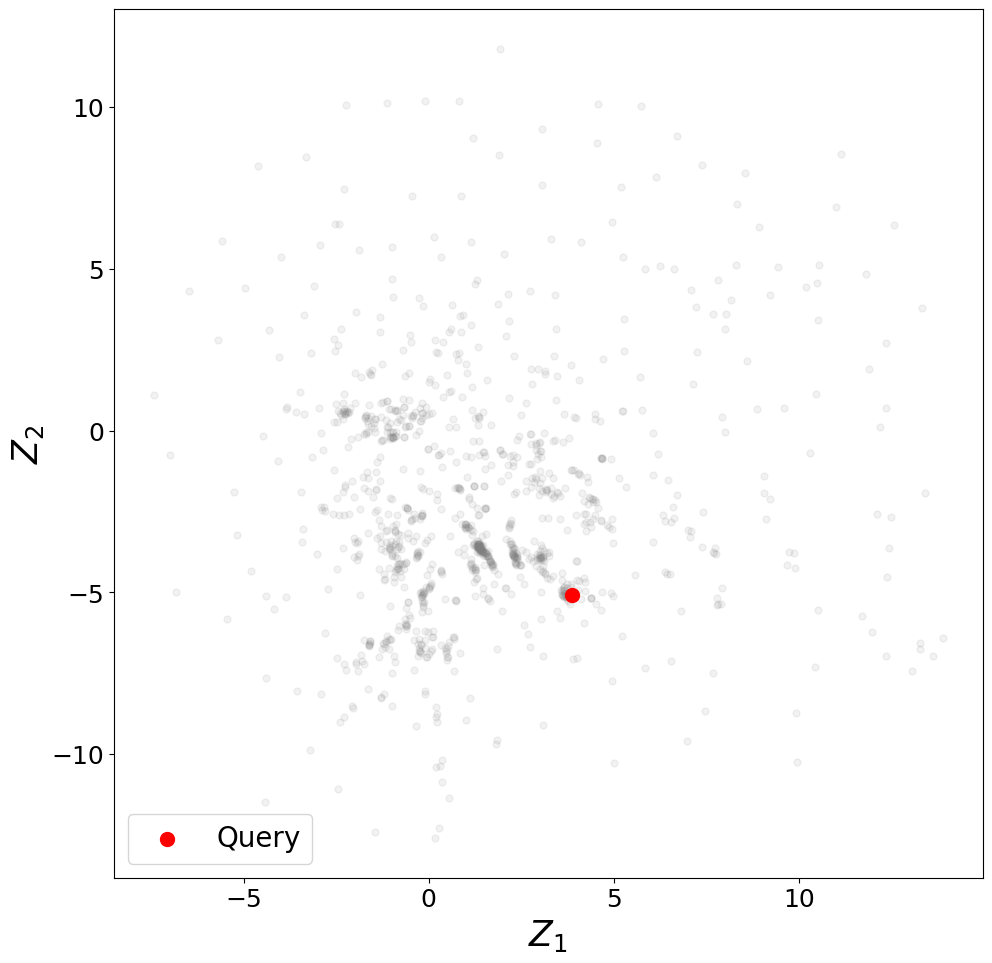

In [6]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
ax.scatter(query_coords[0], query_coords[1], marker='o', s=100, color='red', label='Query',zorder=1)

# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)

plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space.png"))
    #ax.set_title(f"Latent space projection final")

In [7]:
# Read the fasta files in a folder and create a new fasta file with all the sequences
def read_fasta_files_in_folder(folder_path,outpath):
    """
    Reads all fasta files in a given folder and writes their sequences to a new fasta file.
    
    :param folder_path: Path to the folder containing fasta files.
    :param outpath: Path to the output fasta file.
    """
    with open(outpath, 'w') as outfile:
        for filename in os.listdir(folder_path):
            if filename.endswith('.fasta') or filename.endswith('.fa'):
                file_path = os.path.join(folder_path, filename)
                with open(file_path, 'r') as infile:
                    for line in infile:
                        outfile.write(line.strip())
                        outfile.write('\n')  # Ensure each sequence is on a new line
    print(f"All sequences from fasta files in {folder_path} have been written to {outpath}.")

In [ ]:
read_fasta_files_in_folder('/Users/dahala/GitHub/VAE-enzymes/random_data/SuSy/singular_fastas',
                           '/Users/dahala/GitHub/VAE-enzymes/random_data/SuSy/AllSuSys.fasta')

All sequences from fasta files in /Users/dahala/GitHub/VAE-enzymes/random_data/SuSy/singular_fastas have been written to /Users/dahala/GitHub/VAE-enzymes/random_data/SuSy/AllSuSys.fasta.


In [12]:
HMMbuild.align('AllSuSys',fasta_ext='fasta',save_path=run.msa)

/Users/dahala/Projects/HMMER/bin/hmmalign --trim --outformat afa ../../hmm_model/GmSuSy_EVC_b05.hmm ../datasets/AllSuSys.fasta > ../../alignments/AllSuSys.afa


In [18]:
HMMbuild.align('BioMatterSeq',fasta_ext='fasta',save_path=run.msa)

/Users/dahala/Projects/HMMER/bin/hmmalign --trim --outformat afa ../../hmm_model/GmSuSy_EVC_b05.hmm ../datasets/BioMatterSeq.fasta > ../../alignments/BioMatterSeq.afa


In [8]:
AllSuSys = SeqIO.to_dict(SeqIO.parse(f'{run.msa}/AllSuSys_fix.afa', 'fasta'))
AllSuSys_seqs = []
AllSuSys_seqs_msa_col = []
for acc, item in AllSuSys.items():
    seq = str(item.seq)
    if len(seq) > 0:
        AllSuSys_seqs.append(seq)
        msa_seq_ = ''.join([seq[s] for s in msa_columns])
        AllSuSys_seqs_msa_col.append(msa_seq_)
    else:
        print(f"⚠ Empty sequence for {acc}")
# Encode all sequences in one batch
mu_alt,_ = latent_space.encode(AllSuSys_seqs_msa_col)

In [9]:
BioMatter = SeqIO.to_dict(SeqIO.parse(f'{run.msa}/BioMatterSeq_fix.afa', 'fasta'))
BioMatter_seqs = []
BioMatter_seqs_msa_col = []
for acc, item in BioMatter.items():
    seq = str(item.seq)
    if len(seq) > 0:
        BioMatter_seqs.append(seq)
        msa_seq_ = ''.join([seq[s] for s in msa_columns])
        BioMatter_seqs_msa_col.append(msa_seq_)
    else:
        print(f"⚠ Empty sequence for {acc}")
# Encode all sequences in one batch
mu_biomatter,_ = latent_space.encode(BioMatter_seqs_msa_col)


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


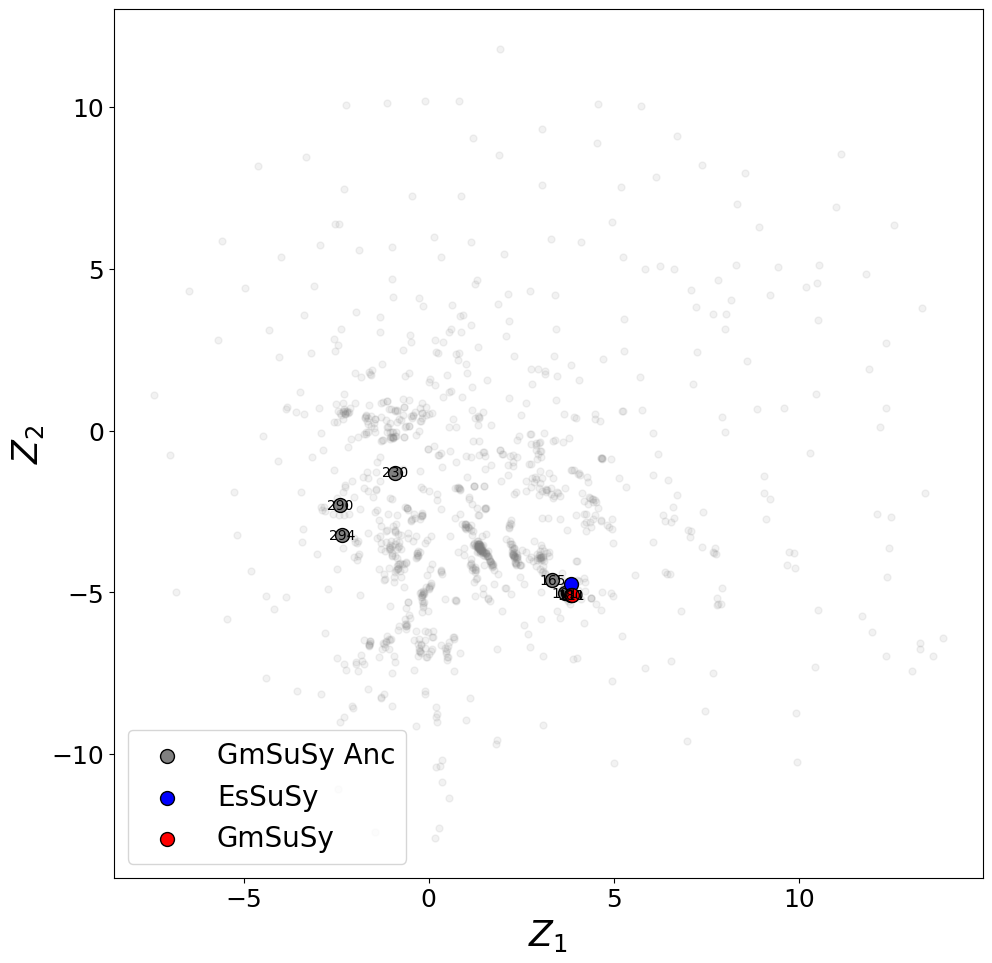

In [10]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
for i, ID in enumerate(list(AllSuSys.keys())):
    if ID == 'EsSuSy':
        ax.scatter(mu_alt[i, 0], mu_alt[i, 1], marker='o', s=100, color='blue', label='EsSuSy',zorder=1,edgecolors='black')
    else:
        number = ID.split('_')[-1]
        ax.annotate(number, (mu_alt[i, 0], mu_alt[i, 1]), fontsize=10, color='black', ha='center', va='center')
        if i == 0:
            ax.scatter(mu_alt[i, 0], mu_alt[i, 1], marker='o', s=100, color='grey', label='GmSuSy Anc',zorder=1,edgecolors='black')
        else:
            ax.scatter(mu_alt[i, 0], mu_alt[i, 1], marker='o', s=100, color='grey', zorder=1,edgecolors='black')
#ax.scatter(mu_biomatter[:, 0], mu_biomatter[:, 1], marker='o', s=100, color='green', label='BioMatterSeq',zorder=1,edgecolors='black')
ax.scatter(query_coords[0], query_coords[1], marker='o', s=100, color='red', label='GmSuSy',zorder=1,edgecolors='black')

# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)

plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space_Es&Anc.png"))
    #ax.set_title(f"Latent space projection final")

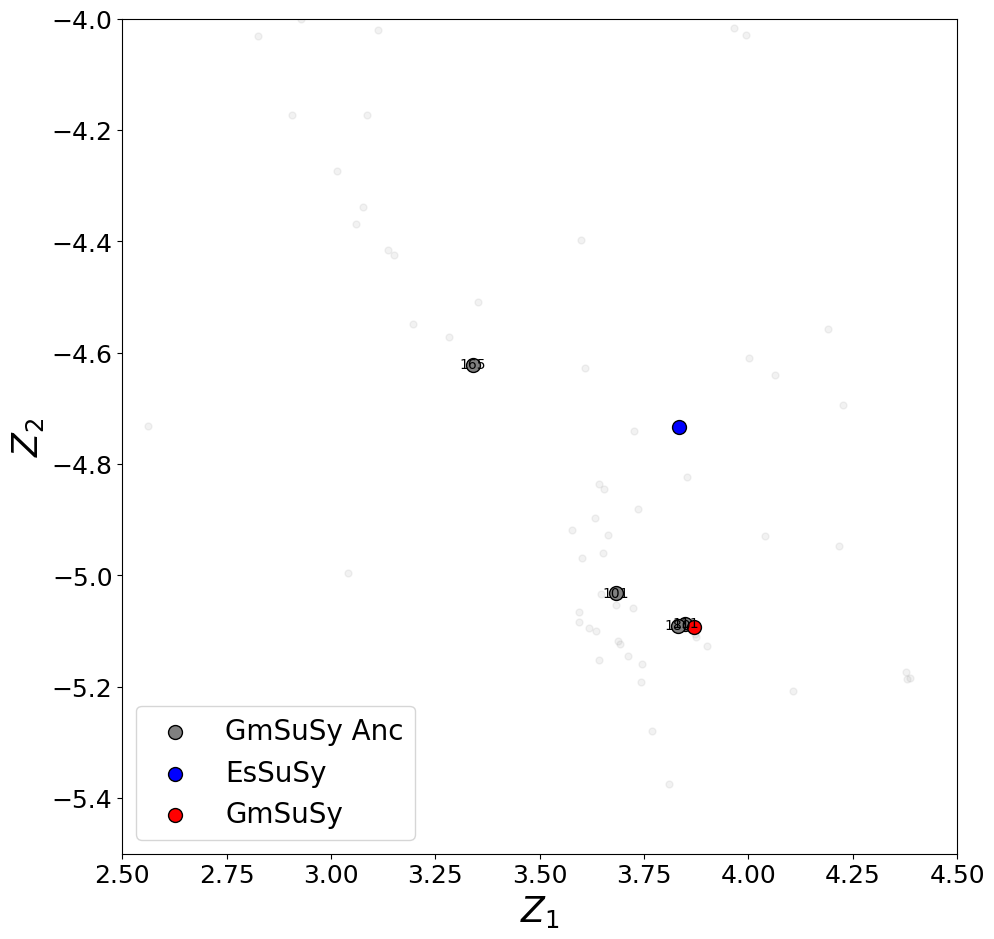

In [11]:
# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
for i, ID in enumerate(list(AllSuSys.keys())):
    if ID == 'EsSuSy':
        ax.scatter(mu_alt[i, 0], mu_alt[i, 1], marker='o', s=100, color='blue', label='EsSuSy',zorder=1,edgecolors='black')
    else:
        number = ID.split('_')[-1]
        ax.annotate(number, (mu_alt[i, 0], mu_alt[i, 1]), fontsize=10, color='black', ha='center', va='center')
        if i == 0:
            ax.scatter(mu_alt[i, 0], mu_alt[i, 1], marker='o', s=100, color='grey', label='GmSuSy Anc',zorder=1,edgecolors='black')
        else:
            ax.scatter(mu_alt[i, 0], mu_alt[i, 1], marker='o', s=100, color='grey', zorder=1,edgecolors='black')
#ax.scatter(mu_biomatter[:, 0], mu_biomatter[:, 1], marker='o', s=100, color='green', label='BioMatterSeq',zorder=1,edgecolors='black')
ax.scatter(query_coords[0], query_coords[1], marker='o', s=100, color='red', label='GmSuSy',zorder=1,edgecolors='black')

# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)

ax.set_xlim(2.5,4.5)
ax.set_ylim(-5.5,-4)

plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space_Es&Anc_Zoom.png"))

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


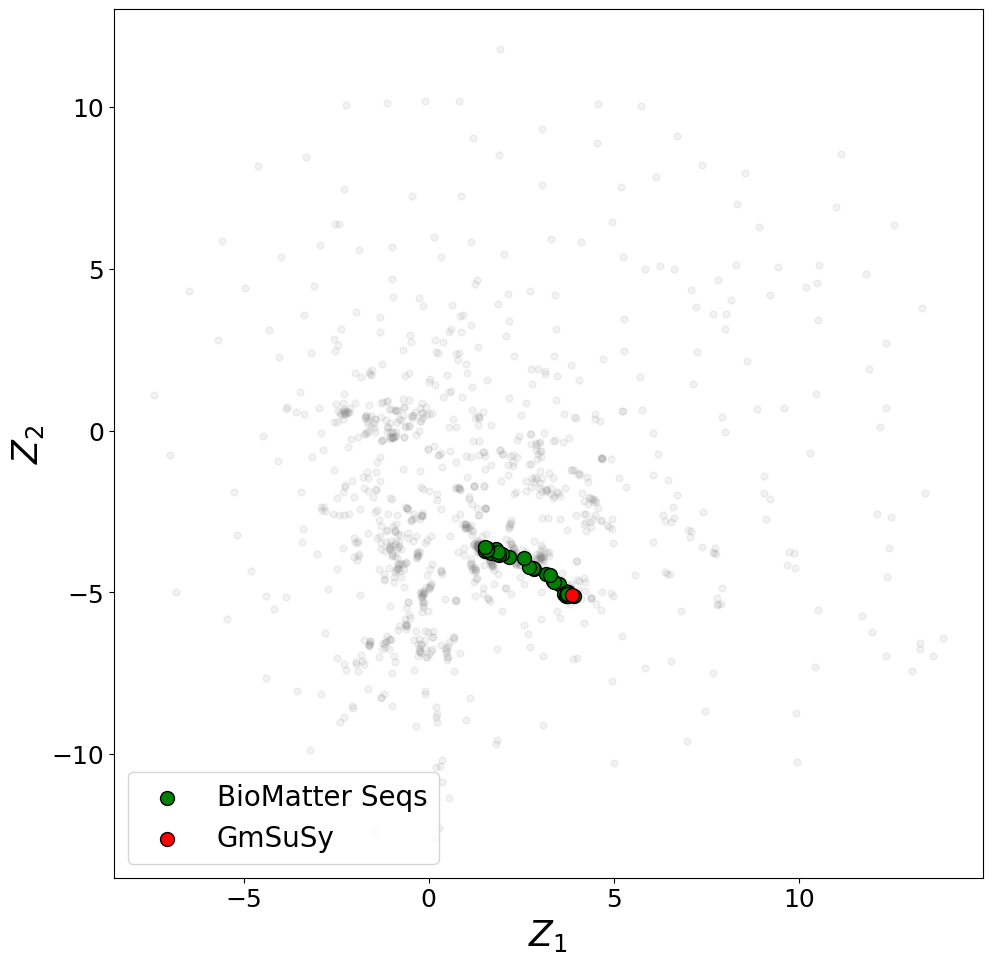

In [12]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
ax.scatter(mu_biomatter[:, 0], mu_biomatter[:, 1], marker='o', s=100, color='green', label='BioMatter Seqs',zorder=1,edgecolors='black')
ax.scatter(query_coords[0], query_coords[1], marker='o', s=100, color='red', label='GmSuSy',zorder=1,edgecolors='black')

# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)


plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space_BioM.png"))
    #ax.set_title(f"Latent space projection final")

In [13]:
biomatter_results = pd.read_excel('../../random_data/SuSy/in silico characterization.xlsx', sheet_name='Conclusions',header=1,index_col=0)
biomatter_results.columns = ['production',	'RelAct', 'ResAct', 'Tm', 'solvent_stability']

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

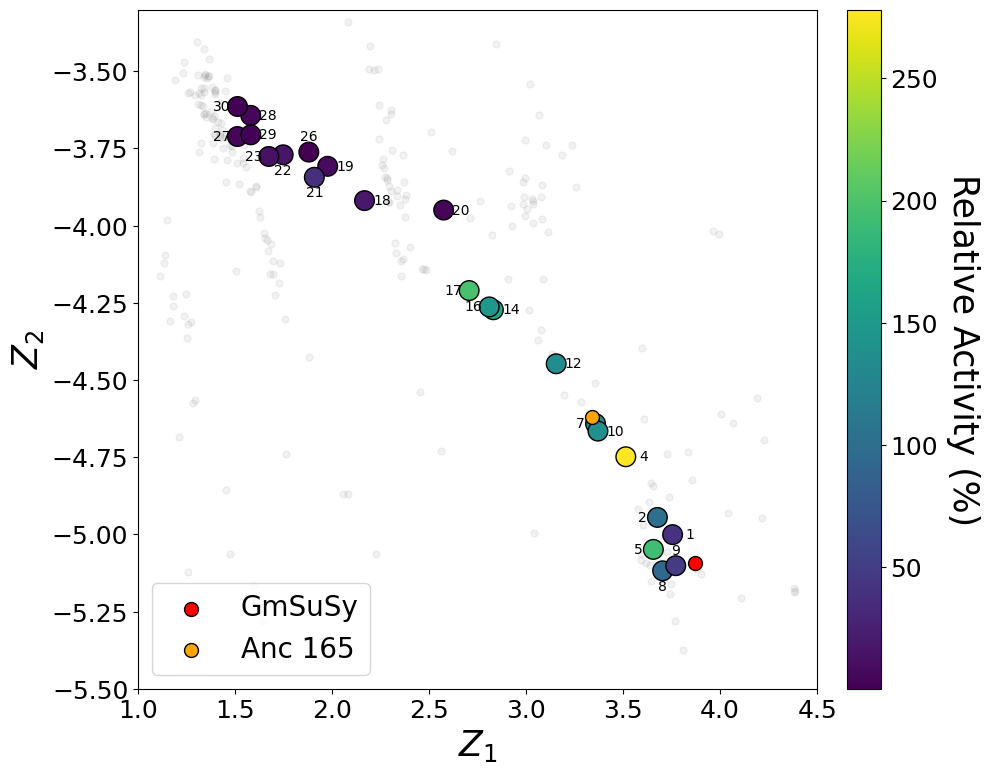

In [14]:
# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
#ax.scatter(mu_biomatter[:, 0], mu_biomatter[:, 1], marker='o', s=100, color='green', label='BioMatter Seqs',zorder=1,edgecolors='black')
ax.scatter(query_coords[0], query_coords[1], marker='o', s=100, color='red', label='GmSuSy',zorder=1,edgecolors='black')

idx_list = []
for i, ID in enumerate(list(BioMatter.keys())):
    #Extract the number from the ID, e.g. P1781B1S1 --> 1
    number = ID.split('S')[-1]
    if 'S'+str(number) in biomatter_results.index:
        rel_act = biomatter_results.loc['S'+str(number), 'RelAct']
        if number in ['1','11', '14','28','29','19','18','20','12','10','4']:
            dx = 0.09
            dy = 0.00
        elif number in ['7','16','30','27','23','17','2','5']:
            dx = -0.08
            dy = -0.00
        elif number in ['21','22','8']:
            dx = 0
            dy = -0.05
        elif number in ['26','9']:
            dx = 0
            dy = 0.05
        else:
            dx = 0
            dy = 0
        ax.annotate(number, (mu_biomatter[i, 0]+dx, mu_biomatter[i, 1]+dy), fontsize=10, color='black', ha='center', va='center')
        idx_list.append(i)

for i, ID in enumerate(list(AllSuSys.keys())):
    if ID == 'Ancestral_165':
        ax.scatter(mu_alt[i, 0], mu_alt[i, 1], marker='o', s=100, color='orange', label='Anc 165',zorder=3,edgecolors='black')

act = ax.scatter(mu_biomatter[idx_list, 0], mu_biomatter[idx_list, 1], marker='o', s=200, c=biomatter_results.RelAct, cmap='viridis', zorder=1, edgecolors='black')
# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)

ax.set_xlim(1,4.5)
ax.set_ylim(-5.5,-3.3)

cb = fig_lat.colorbar(act,ax=ax,fraction=0.04569, pad=0.04)
cb.ax.tick_params(labelsize=18)
cb.set_label('Relative Activity (%)',fontsize=25,rotation=270,labelpad=30)


plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space_BioM_Zoom_relact.png"))

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

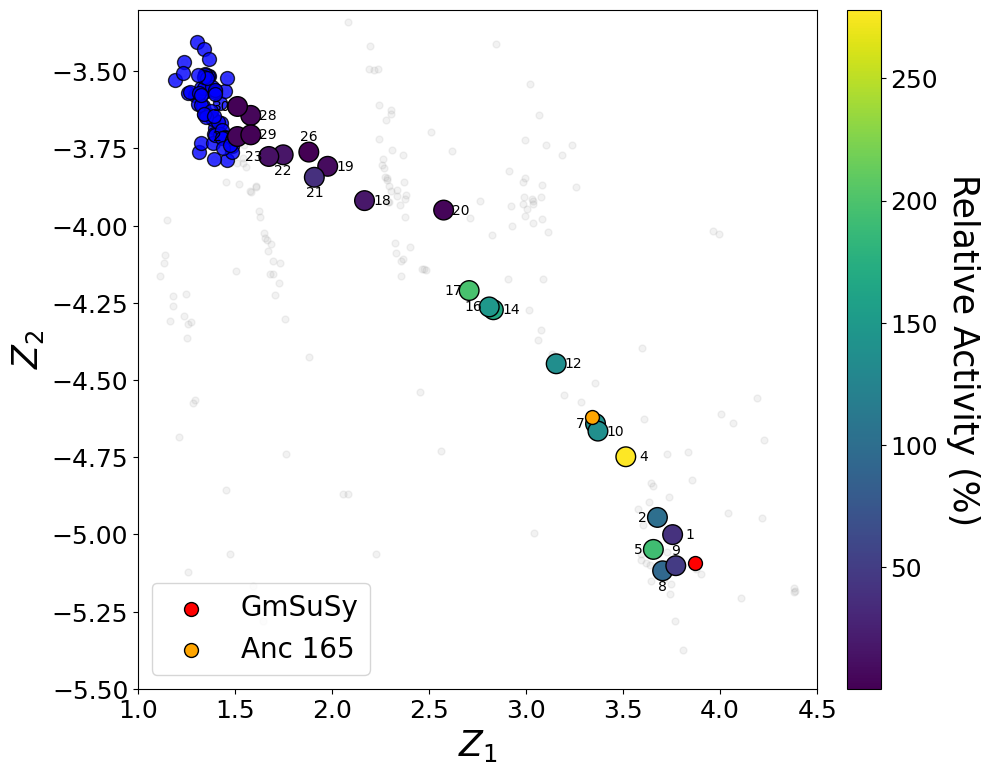

In [25]:
# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
#ax.scatter(mu_biomatter[:, 0], mu_biomatter[:, 1], marker='o', s=100, color='green', label='BioMatter Seqs',zorder=1,edgecolors='black')
ax.scatter(query_coords[0], query_coords[1], marker='o', s=100, color='red', label='GmSuSy',zorder=1,edgecolors='black')

idx_list = []
for i, ID in enumerate(list(BioMatter.keys())):
    #Extract the number from the ID, e.g. P1781B1S1 --> 1
    number = ID.split('S')[-1]
    if 'S'+str(number) in biomatter_results.index:
        rel_act = biomatter_results.loc['S'+str(number), 'RelAct']
        if number in ['1','11', '14','28','29','19','18','20','12','10','4']:
            dx = 0.09
            dy = 0.00
        elif number in ['7','16','30','27','23','17','2','5']:
            dx = -0.08
            dy = -0.00
        elif number in ['21','22','8']:
            dx = 0
            dy = -0.05
        elif number in ['26','9']:
            dx = 0
            dy = 0.05
        else:
            dx = 0
            dy = 0
        ax.annotate(number, (mu_biomatter[i, 0]+dx, mu_biomatter[i, 1]+dy), fontsize=10, color='black', ha='center', va='center')
        idx_list.append(i)

for i, ID in enumerate(list(AllSuSys.keys())):
    if ID == 'Ancestral_165':
        ax.scatter(mu_alt[i, 0], mu_alt[i, 1], marker='o', s=100, color='orange', label='Anc 165',zorder=3,edgecolors='black')

act = ax.scatter(mu_biomatter[idx_list, 0], mu_biomatter[idx_list, 1], marker='o', s=200, c=biomatter_results.RelAct, cmap='viridis', zorder=1, edgecolors='black')
# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)


mask_x = (msa_embeddings[:, 0]<1.5) & (msa_embeddings[:, 0]>1)
mask_y = (msa_embeddings[:, 1]<-3.4) & (msa_embeddings[:, 1]>-3.8)

mask = mask_x & mask_y
msa_embeddings_sel = msa_embeddings[mask]

ax.scatter(msa_embeddings_sel[:, 0], msa_embeddings_sel[:, 1], color='blue',edgecolor='black',s=100,alpha=0.8,zorder=0,label='Selection')


ax.set_xlim(1,4.5)
ax.set_ylim(-5.5,-3.3)

cb = fig_lat.colorbar(act,ax=ax,fraction=0.04569, pad=0.04)
cb.ax.tick_params(labelsize=18)
cb.set_label('Relative Activity (%)',fontsize=25,rotation=270,labelpad=30)


plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space_BioM_Zoom_relact_selection.png"))

In [32]:
msa_sel_id = []
for inbtw in msa_embeddings_sel:
    for i, emb in enumerate(msa_embeddings):
        if torch.equal(torch.tensor(emb), torch.tensor(inbtw)):
            print(msa_keys[i])
            msa_sel_id.append(msa_keys[i])
            #print(msa[msa_keys[i]])

/var/folders/4n/74gpb5hj01g0m2nkznhtyjrr0000gp/T/ipykernel_7054/3828539514.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if torch.equal(torch.tensor(emb), torch.tensor(inbtw)):


A0A0B0MYK2
A0A0L9UAA1
A0A8T0L3Z0
A0A151S836
A0A166HFZ3
A0A1J7GZ61
A0A1Q3DG94
A0A1S2XYL1
A0A1U8A006
A0A1U8APR5
A0A200QSH1
A0A2C9WN63
A0A2I4EZE2
A0A2N9IBR6
A0A2P5CZ46
A0A2P6PWV7
A0A2Z7AK78
A0A2Z7CR67
A0A443PTV3
A0A4S4EG04
A0A4Y7IW89
A0A5C7I488
A0A5J5BK21
A0A5J9WFP1
A0A6A4QXD4
A0A6P4ACG8
A0A6P5RJQ4
A0A6P6B175
A0A6P8C375
A0A7H1RHJ4
A0A7J7DCL9
A0A7N0R9Y4
A0A7N2N488
A0A834M236
A0A834SIN8
A0A834YNT5
A0A835D4J4
A0A8B8Q9J1
A0A8K0DWD7
A0A0L9UAA1
A0A8T0L3Z0
A5C6H7
B9GSC7
I7FQF1
K4HUT4
O24301
Q9M111
Q9SLV8
S4TGT8
V5K950
V7CY85
UPI00053C47F5
UPI0010A510DA
UPI001C4E7176
UPI001C4F40FE
UPI001FB16C50
UPI0020240749
UPI0021604F00
UPI002256BDB1
UPI002258A5BE
A0A166HFY5


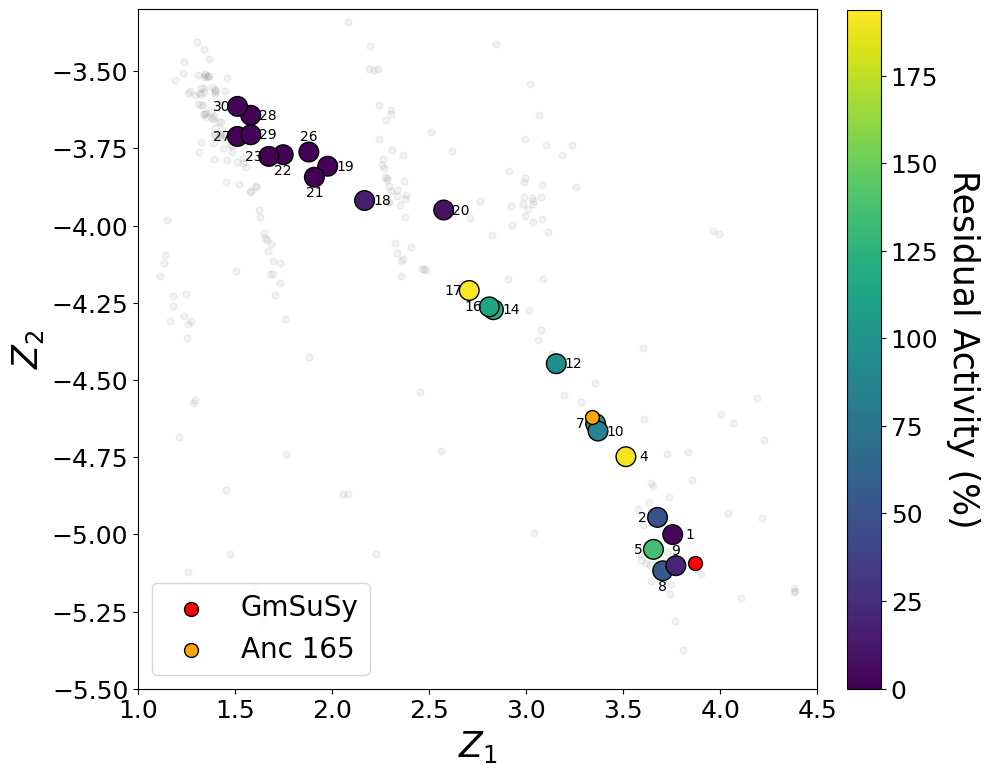

In [93]:
# Projection to the latent space
# Show your queries
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
#ax.scatter(mu_biomatter[:, 0], mu_biomatter[:, 1], marker='o', s=100, color='green', label='BioMatter Seqs',zorder=1,edgecolors='black')
ax.scatter(query_coords[0], query_coords[1], marker='o', s=100, color='red', label='GmSuSy',zorder=1,edgecolors='black')

idx_list = []
for i, ID in enumerate(list(BioMatter.keys())):
    #Extract the number from the ID, e.g. P1781B1S1 --> 1
    number = ID.split('S')[-1]
    if 'S'+str(number) in biomatter_results.index:
        rel_act = biomatter_results.loc['S'+str(number), 'ResAct']
        if number in ['1','11', '14','28','29','19','18','20','12','10','4']:
            dx = 0.09
            dy = 0.00
        elif number in ['7','16','30','27','23','17','2','5']:
            dx = -0.08
            dy = -0.00
        elif number in ['21','22','8']:
            dx = 0
            dy = -0.05
        elif number in ['26','9']:
            dx = 0
            dy = 0.05
        else:
            dx = 0
            dy = 0
        ax.annotate(number, (mu_biomatter[i, 0]+dx, mu_biomatter[i, 1]+dy), fontsize=10, color='black', ha='center', va='center')
        idx_list.append(i)

for i, ID in enumerate(list(AllSuSys.keys())):
    if ID == 'Ancestral_165':
        ax.scatter(mu_alt[i, 0], mu_alt[i, 1], marker='o', s=100, color='orange', label='Anc 165',zorder=3,edgecolors='black')

act = ax.scatter(mu_biomatter[idx_list, 0], mu_biomatter[idx_list, 1], marker='o', s=200, c=biomatter_results.ResAct, cmap='viridis', zorder=1, edgecolors='black')
# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)

ax.set_xlim(1,4.5)
ax.set_ylim(-5.5,-3.3)

cb = fig_lat.colorbar(act,ax=ax,fraction=0.04569, pad=0.04)
cb.ax.tick_params(labelsize=18)
cb.set_label('Residual Activity (%)',fontsize=25,rotation=270,labelpad=30)


plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space_BioM_Zoom_resact.png"))

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

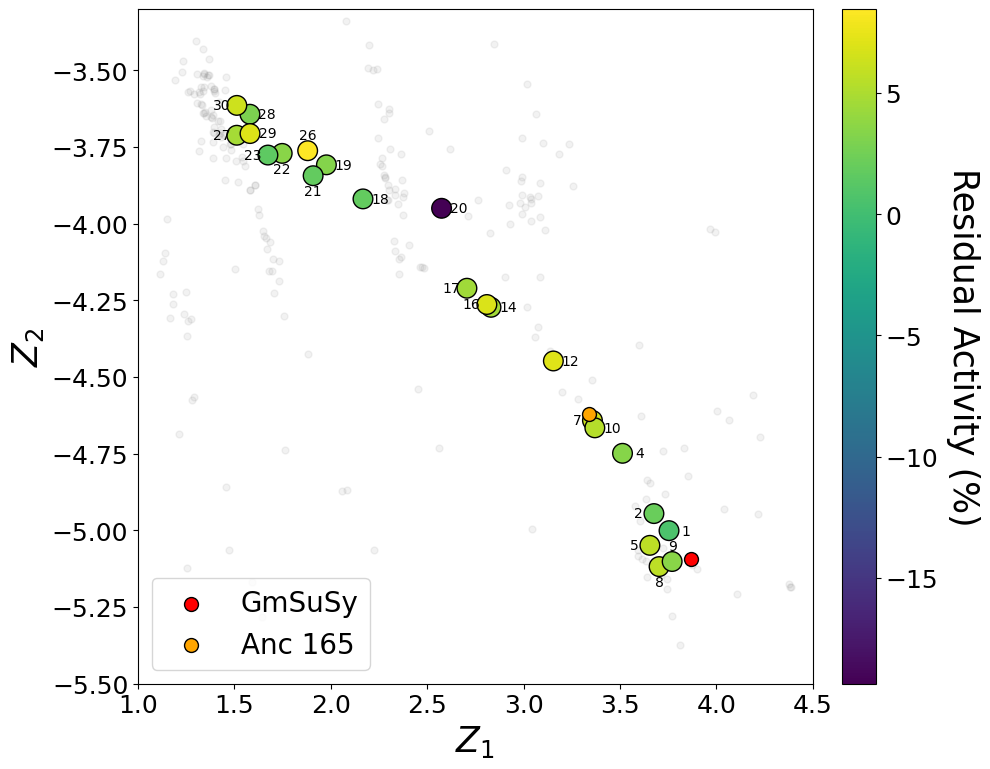

In [15]:
run.weights = f'{run.result}/model/vae_fold_0.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]


query_coords = latent_space.key_to_embedding(run.fixed_sequences)


fig_lat, ax = plt.subplots(1, 1,figsize=(10,10))

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=10, color='grey',zorder=0)
#ax.scatter(mu_biomatter[:, 0], mu_biomatter[:, 1], marker='o', s=100, color='green', label='BioMatter Seqs',zorder=1,edgecolors='black')
ax.scatter(query_coords[0], query_coords[1], marker='o', s=100, color='red', label='GmSuSy',zorder=1,edgecolors='black')

idx_list = []
for i, ID in enumerate(list(BioMatter.keys())):
    #Extract the number from the ID, e.g. P1781B1S1 --> 1
    number = ID.split('S')[-1]
    if 'S'+str(number) in biomatter_results.index:
        rel_act = biomatter_results.loc['S'+str(number), 'ResAct']
        if number in ['1','11', '14','28','29','19','18','20','12','10','4']:
            dx = 0.09
            dy = 0.00
        elif number in ['7','16','30','27','23','17','2','5']:
            dx = -0.08
            dy = -0.00
        elif number in ['21','22','8']:
            dx = 0
            dy = -0.05
        elif number in ['26','9']:
            dx = 0
            dy = 0.05
        else:
            dx = 0
            dy = 0
        ax.annotate(number, (mu_biomatter[i, 0]+dx, mu_biomatter[i, 1]+dy), fontsize=10, color='black', ha='center', va='center')
        idx_list.append(i)

for i, ID in enumerate(list(AllSuSys.keys())):
    if ID == 'Ancestral_165':
        ax.scatter(mu_alt[i, 0], mu_alt[i, 1], marker='o', s=100, color='orange', label='Anc 165',zorder=3,edgecolors='black')

act = ax.scatter(mu_biomatter[idx_list, 0], mu_biomatter[idx_list, 1], marker='o', s=200, c=biomatter_results.Tm, cmap='viridis', zorder=1, edgecolors='black')
# Project 
ax.legend(loc='lower left', fontsize=20)
ax.tick_params(labelsize=18)
ax.set_xlabel(r'$Z_1$', fontsize=25)
ax.set_ylabel(r'$Z_2$', fontsize=25)
ax.set_box_aspect(1)

ax.set_xlim(1,4.5)
ax.set_ylim(-5.5,-3.3)

cb = fig_lat.colorbar(act,ax=ax,fraction=0.04569, pad=0.04)
cb.ax.tick_params(labelsize=18)
cb.set_label('Residual Activity (%)',fontsize=25,rotation=270,labelpad=30)


plt.tight_layout()
fig_lat.savefig(os.path.join(run.results, f"latent_space_BioM_Zoom_Tm.png"))

In [28]:
import requests
from more_itertools import chunked
from time import sleep
import re

def batch_fetch_uniprot_sequences(ids, batch_size=500):
    sequences = {}
    fallback_ids = []
    
    # Updated matching rule
    def is_uniprot_accession(s):
        return bool(re.fullmatch(r"[A-Z0-9]{6,10}", s))

    uniprot_ids = []
    for i in ids:
        i = str(i).strip()
        if is_uniprot_accession(i):
            uniprot_ids.append(i)
        else:
            fallback_ids.append(i)

    for batch in chunked(uniprot_ids, batch_size):
        query = " OR ".join([f"accession:{uid}" for uid in batch])
        url = "https://rest.uniprot.org/uniprotkb/stream"
        headers = {"Accept": "text/x-fasta"}
        params = {"query": query, "format": "fasta"}

        response = requests.get(url, headers=headers, params=params)

        retrieved_ids = set()

        if response.status_code == 200:
            fasta_data = response.text.splitlines()
            current_id = None
            seq_lines = []
            for line in fasta_data:
                if line.startswith(">"):
                    if current_id:
                        sequences[current_id] = ''.join(seq_lines)
                        retrieved_ids.add(current_id)
                    current_id = line.split('|')[1]
                    seq_lines = []
                else:
                    seq_lines.append(line)
            if current_id:
                sequences[current_id] = ''.join(seq_lines)
                retrieved_ids.add(current_id)
        else:
            # Whole batch failed
            fallback_ids.extend(batch)
            continue

        # Any UniProt IDs that didn't return?
        missing_in_batch = set(batch) - retrieved_ids
        fallback_ids.extend(missing_in_batch)

        sleep(1)

    return sequences, fallback_ids

def fallback_fetch_uniparc(ids):
    sequences = {}
    still_failed = []

    for uid in ids:
        if not uid.startswith("UPI"):
            still_failed.append(uid)
            continue

        url = f"https://rest.uniprot.org/uniparc/{uid}.fasta"
        response = requests.get(url)
        if response.status_code == 200:
            seq = ''.join(response.text.splitlines()[1:])
            sequences[uid] = seq
        else:
            sequences[uid] = None
            still_failed.append(uid)

        sleep(0.3)  # polite

    return sequences, still_failed


In [33]:
seqs_upkb, fallback_needed = batch_fetch_uniprot_sequences(msa_sel_id)

In [37]:
seqs_uniparc, manual_review = fallback_fetch_uniparc(fallback_needed)

In [38]:
manual_review

['A0A166HFY5']

In [39]:
manual_seqs = {'A0A166HFY5':'MATRELKKLPSIRDRVEDTLSAHRNELVSLLSRYVAQGKGILQPHHLIDELESSIGDEDSGKHHLRDGLFGQILQSTQEAIILPPFVAIAVRPRPGVWEYVRLNVYELSVEQLDVSQYLHFKEELVNGQIDDKFMLELDFEPFNATVPRPTRSSSIGNGVQFLNRHLSSIMFRNKDCLEPLLNFLQAHNYKGHVMMINDRIRSISRLESALTKAEDYLSKQLPDAPFSQFEYDLQGMGFEKGWGDTAERVLEMMHLLSDILQAPDPASLETFLGRIPMVFNVVILSVHGFFGQANVLGLPDTGGQIVYILDQVRALENEMLLKLKQQGLNITPRILIVTRLIPDAKGTTCNQRLERVSGTDHTHILRVPFRTEHGVLRKWISRFDDAASEICAELQGNPDLIIGNYSDGNLVASLLSYKMGVTQCTIAHALEKTKYPDSDIYWKKFDEKYHFSCQFTADLIAMNNADFIITSTYQEIAGTKDTVGQYESHSSFTLPGLYRVVHGIDVFDPKFNIVSPGADMCIYFPYSEKEKRLTSLHGSIEKLLYDPEQNEEHVGSLSDHSKPMIFSMARLDRVKNITGLVECYAKNTKLRELANLVIVAGYNDVKKSNDREEVVEIQKMHDLIKQYSLDGQLRWISSQTNRARNGELYRYIADKRGIFVQPAFYEAFGLTVVEAMTCGLPTFATRHGGPREIIEDGVSGFHIDPYHPDKAADLMAEFFQKCTKDPAYWEKISEGGLQRIYERYTWKIYSERLMTLAGVYSFWKYVSKLERRETRRYLEMFYILKFRELVKSVPLAIDEEATDESGDTLNAEYDLYSVY'
}

In [43]:
import requests
import re
from time import sleep

def fetch_uniprot_annotation(uid):
    url = f"https://rest.uniprot.org/uniprotkb/{uid}.json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()

        # Protein name
        name = data.get("proteinDescription", {}).get("recommendedName", {}).get("fullName", {}).get("value", None)

        # EC number
        ec_list = data.get("proteinDescription", {}).get("recommendedName", {}).get("ecNumbers", [])
        ec_number = ec_list[0]["value"] if ec_list else None

        # Functional comment
        comments = data.get("comments", [])
        function = next(
            (c["texts"][0]["value"] for c in comments if c.get("commentType") == "FUNCTION"),
            None
        )

        if name or ec_number or function:
            return {
                "id": uid,
                "name": name,
                "ec_number": ec_number,
                "function": function
            }

    return None  # Either 404 or no useful annotation

def fetch_uniprot_annotations_only(ids):
    annotations = {}
    missing = []

    def is_uniprot_id(uid):
        return bool(re.fullmatch(r"[A-Z0-9]{6,10}", uid))

    for uid in ids:
        uid = uid.strip()
        if not is_uniprot_id(uid):
            missing.append(uid)
            continue

        ann = fetch_uniprot_annotation(uid)
        if ann:
            annotations[uid] = ann
        else:
            missing.append(uid)

        sleep(0.2)

    return annotations, missing



In [44]:
annotations, missing = fetch_uniprot_annotations_only(msa_sel_id)

In [51]:
import pprint
pprint.pprint(annotations)

{'A0A0B0MYK2': {'ec_number': '2.4.1.13',
                'function': 'Sucrose-cleaving enzyme that provides UDP-glucose '
                            'and fructose for various metabolic pathways',
                'id': 'A0A0B0MYK2',
                'name': 'Sucrose synthase'},
 'A0A0L9UAA1': {'ec_number': '2.4.1.13',
                'function': 'Sucrose-cleaving enzyme that provides UDP-glucose '
                            'and fructose for various metabolic pathways',
                'id': 'A0A0L9UAA1',
                'name': 'Sucrose synthase'},
 'A0A151S836': {'ec_number': '2.4.1.13',
                'function': 'Sucrose-cleaving enzyme that provides UDP-glucose '
                            'and fructose for various metabolic pathways',
                'id': 'A0A151S836',
                'name': 'Sucrose synthase'},
 'A0A166HFZ3': {'ec_number': '2.4.1.13',
                'function': 'Sucrose-cleaving enzyme that provides UDP-glucose '
                            'and fructose fo

In [46]:
missing

['UPI00053C47F5',
 'UPI0010A510DA',
 'UPI001C4E7176',
 'UPI001C4F40FE',
 'UPI001FB16C50',
 'UPI0020240749',
 'UPI0021604F00',
 'UPI002256BDB1',
 'UPI002258A5BE',
 'A0A166HFY5']

# Benchmark GASPhmm

In [22]:
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm/benchmark/marginals_benchmark.csv'
benchmark_pd = pd.read_csv(benchmark_path,index_col=0)
benchmark_pd.min().min()

0.1317129840546701

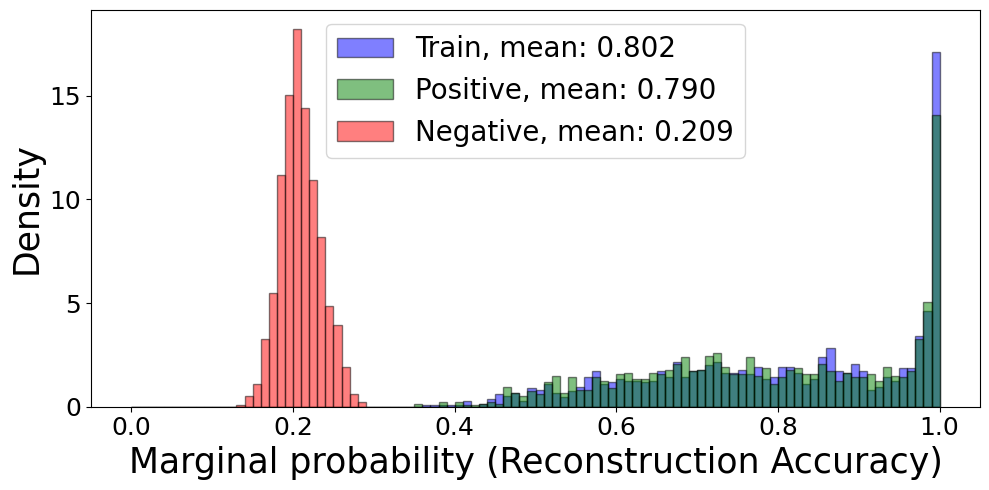

In [23]:
#Plotting the benchmark results

fig_bench, ax = plt.subplots(1, 1,figsize=(10,5))
ax.hist(benchmark_pd['Train'],bins=100,range=(0,1),alpha=0.5,color='blue',edgecolor='black',label=f'Train, mean: {benchmark_pd.Train.mean():.3f}',density=True)
ax.hist(benchmark_pd['Positive'],bins=100,range=(0,1),alpha=0.5,color='green',edgecolor='black',label=f'Positive, mean: {benchmark_pd.Positive.mean():.3f}',density=True)
ax.hist(benchmark_pd['Negative'],bins=100,range=(0,1),alpha=0.5,color='red',edgecolor='black',label=f'Negative, mean: {benchmark_pd.Negative.mean():.3f}',density=True)


ax.set_xlabel('Marginal probability (Reconstruction Accuracy)', fontsize=25)
ax.set_ylabel('Density', fontsize=25)
ax.legend(loc='upper center', fontsize=20)
ax.tick_params(labelsize=18)
#ax.set_title('Benchmark results',fontsize=30)
plt.tight_layout()
fig_bench.savefig(os.path.join(run.results, f"benchmark.png"))

plt.show()

In [24]:
benchmark_ls5_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm_ls5/benchmark/marginals_benchmark.csv'
benchmark_ls5_pd = pd.read_csv(benchmark_ls5_path,index_col=0)
benchmark_ls5_pd.min().min()

0.0989339407744878

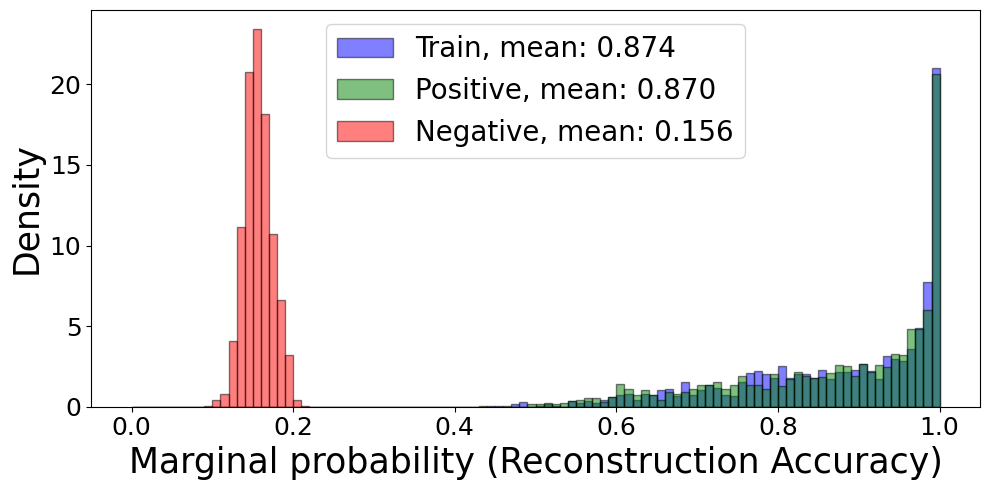

In [25]:
#Plotting the benchmark results

fig_bench, ax = plt.subplots(1, 1,figsize=(10,5))
ax.hist(benchmark_ls5_pd['Train'],bins=100,range=(0,1),alpha=0.5,color='blue',edgecolor='black',label=f'Train, mean: {benchmark_ls5_pd.Train.mean():.3f}',density=True)
ax.hist(benchmark_ls5_pd['Positive'],bins=100,range=(0,1),alpha=0.5,color='green',edgecolor='black',label=f'Positive, mean: {benchmark_ls5_pd.Positive.mean():.3f}',density=True)
ax.hist(benchmark_ls5_pd['Negative'],bins=100,range=(0,1),alpha=0.5,color='red',edgecolor='black',label=f'Negative, mean: {benchmark_ls5_pd.Negative.mean():.3f}',density=True)


ax.set_xlabel('Marginal probability (Reconstruction Accuracy)', fontsize=25)
ax.set_ylabel('Density', fontsize=25)
ax.legend(loc='upper center', fontsize=20)
ax.tick_params(labelsize=18)
#ax.set_title('Benchmark results',fontsize=30)
plt.tight_layout()
fig_bench.savefig(os.path.join(run.results, f"benchmark.png"))

plt.show()

In [26]:
benchmark_ls10_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm_ls10/benchmark/marginals_benchmark.csv'
benchmark_ls10_pd = pd.read_csv(benchmark_ls10_path,index_col=0)
benchmark_ls10_pd['Train'].mean()

0.8966906761850514

In [27]:
f'Train, mean: {benchmark_ls10_pd.Train.mean():.3f}'

'Train, mean: 0.897'

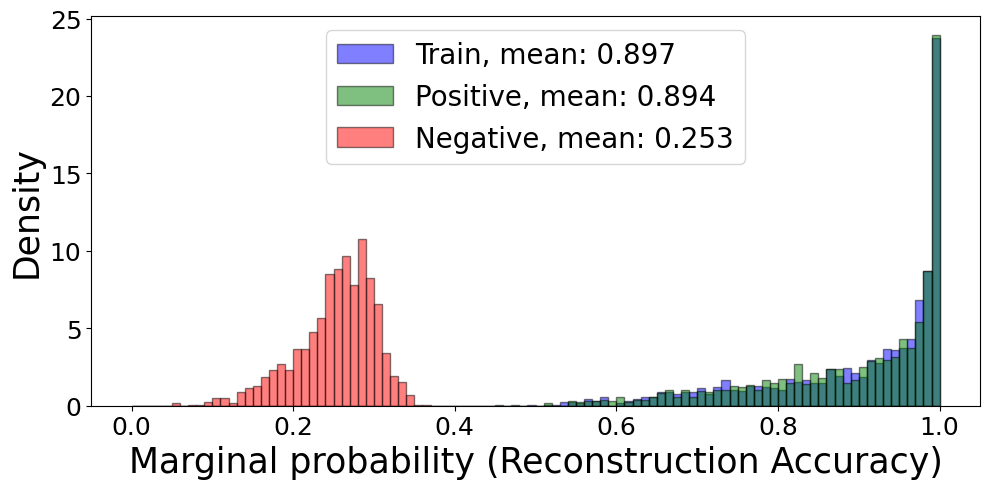

In [28]:
#Plotting the benchmark results

fig_bench, ax = plt.subplots(1, 1,figsize=(10,5))
ax.hist(benchmark_ls10_pd['Train'],bins=100,range=(0,1),alpha=0.5,color='blue',edgecolor='black',label=f'Train, mean: {benchmark_ls10_pd.Train.mean():.3f}',density=True)
ax.hist(benchmark_ls10_pd['Positive'],bins=100,range=(0,1),alpha=0.5,color='green',edgecolor='black',label=f'Positive, mean: {benchmark_ls10_pd.Positive.mean():.3f}',density=True)
ax.hist(benchmark_ls10_pd['Negative'],bins=100,range=(0,1),alpha=0.5,color='red',edgecolor='black',label=f'Negative, mean: {benchmark_ls10_pd.Negative.mean():.3f}',density=True)

ax.set_xlabel('Marginal probability (Reconstruction Accuracy)', fontsize=25)
ax.set_ylabel('Density', fontsize=25)
ax.legend(loc='upper center', fontsize=20)
ax.tick_params(labelsize=18)
#ax.set_title('Benchmark results',fontsize=30)
plt.tight_layout()
fig_bench.savefig(os.path.join(run.results, f"benchmark.png"))

plt.show()

In [68]:
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm/logs/train_log.txt'
benchmark_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=16,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_pd[3] = benchmark_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm_ls5/logs/train_log.txt'
benchmark_ls5_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=16,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_ls5_pd[3] = benchmark_ls5_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm_ls10/logs/train_log.txt'
benchmark_ls10_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=16,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_ls10_pd[3] = benchmark_ls10_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_GASPhmm_lay400to200_ls100/logs/train_log.txt'
benchmark_lay400to200_ls100_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=16,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_lay400to200_ls100_pd[3] = benchmark_lay400to200_ls100_pd[3].str.replace(',','').astype(float)

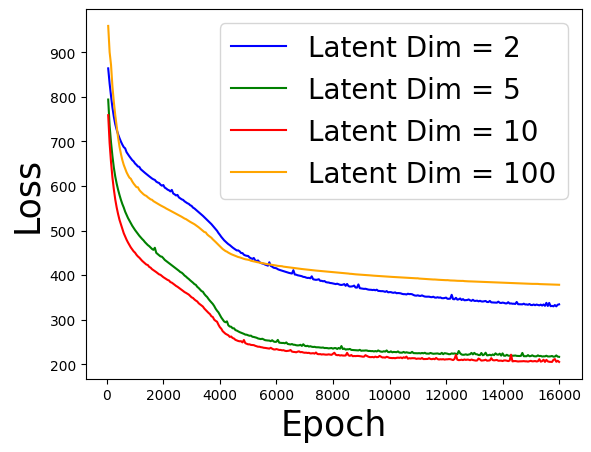

In [69]:
plt.plot(benchmark_pd[3],benchmark_pd[5],label='Latent Dim = 2',color='blue')
plt.plot(benchmark_ls5_pd[3],benchmark_ls5_pd[5],label='Latent Dim = 5',color='green')
plt.plot(benchmark_ls10_pd[3],benchmark_ls10_pd[5],label='Latent Dim = 10',color='red')
plt.plot(benchmark_lay400to200_ls100_pd[3],benchmark_lay400to200_ls100_pd[5],label='Latent Dim = 100',color='orange')
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss',fontsize=25)
plt.legend(loc='upper right', fontsize=20)


# Benchmark CharactNArch

In [31]:
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_charactNarch/benchmark/marginals_benchmark.csv'
benchmark_pd = pd.read_csv(benchmark_path,index_col=0)
benchmark_pd.min().min()

0.1502183622828789

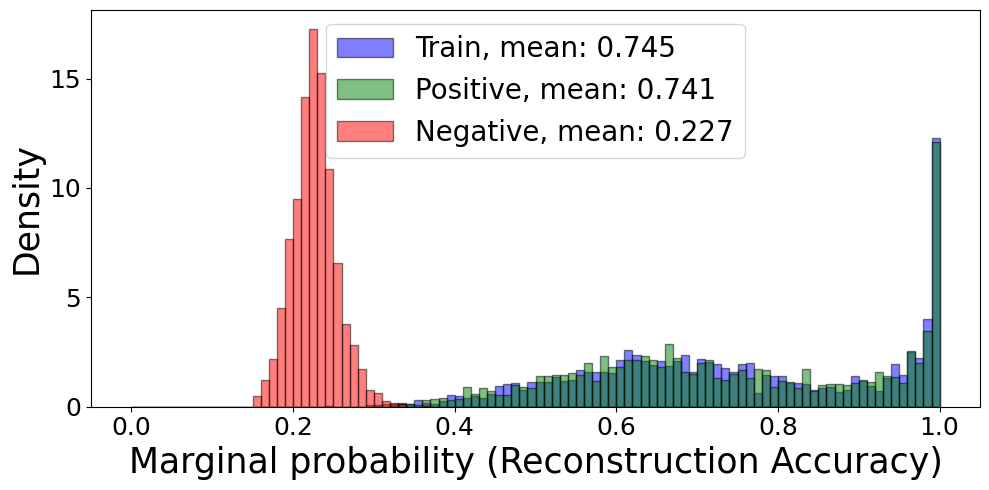

In [32]:
#Plotting the benchmark results

fig_bench, ax = plt.subplots(1, 1,figsize=(10,5))
ax.hist(benchmark_pd['Train'],bins=100,range=(0,1),alpha=0.5,color='blue',edgecolor='black',label=f'Train, mean: {benchmark_pd.Train.mean():.3f}',density=True)
ax.hist(benchmark_pd['Positive'],bins=100,range=(0,1),alpha=0.5,color='green',edgecolor='black',label=f'Positive, mean: {benchmark_pd.Positive.mean():.3f}',density=True)
ax.hist(benchmark_pd['Negative'],bins=100,range=(0,1),alpha=0.5,color='red',edgecolor='black',label=f'Negative, mean: {benchmark_pd.Negative.mean():.3f}',density=True)


ax.set_xlabel('Marginal probability (Reconstruction Accuracy)', fontsize=25)
ax.set_ylabel('Density', fontsize=25)
ax.legend(loc='upper center', fontsize=20)
ax.tick_params(labelsize=18)
#ax.set_title('Benchmark results',fontsize=30)
plt.tight_layout()
fig_bench.savefig(os.path.join(run.results, f"benchmark.png"))

plt.show()

In [70]:
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_charactNarch/logs/train_log.txt'
benchmark_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=21,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_pd[3] = benchmark_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_charactNarch_ls5/logs/train_log.txt'
benchmark_ls5_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=21,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_ls5_pd[3] = benchmark_ls5_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_charactNarch_ls10/logs/train_log.txt'
benchmark_ls10_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=21,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_ls10_pd[3] = benchmark_ls10_pd[3].str.replace(',','').astype(float)
benchmark_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/Cazy_GT1_trim_200_1000_charactNarch_lay400to200_ls100/logs/train_log.txt'
benchmark_lay400to200_ls100_pd = pd.read_csv(benchmark_path,skiprows=3,skipfooter=21,header=None,engine='python',sep='\s+')[[3,5]]
benchmark_lay400to200_ls100_pd[3] = benchmark_lay400to200_ls100_pd[3].str.replace(',','').astype(float)

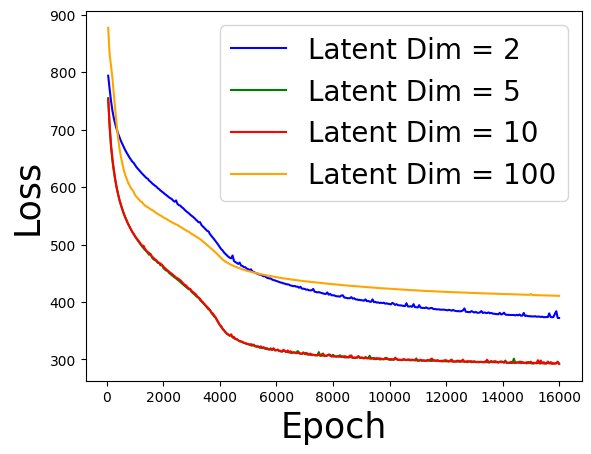

In [71]:
plt.plot(benchmark_pd[3],benchmark_pd[5],label='Latent Dim = 2',color='blue')
plt.plot(benchmark_ls5_pd[3],benchmark_ls5_pd[5],label='Latent Dim = 5',color='green')
plt.plot(benchmark_ls10_pd[3],benchmark_ls10_pd[5],label='Latent Dim = 10',color='red')
plt.plot(benchmark_lay400to200_ls100_pd[3],benchmark_lay400to200_ls100_pd[5],label='Latent Dim = 100',color='orange')
plt.xlabel('Epoch',fontsize=25)
plt.ylabel('Loss',fontsize=25)
plt.legend(loc='upper right', fontsize=20)